<a href="https://colab.research.google.com/github/fberetta8/ML_in_Finance_Spring_2025_ETH/blob/main/Solution5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits for this exercise to [Songyan Hou](https://justinhou95.github.io/), who taught the class in FS23.

In [ ]:
# Need a certain version of numpy

!pip uninstall numpy -y
!pip cache purge
!pip install numpy==1.26.0 --no-cache-dir

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
print(np.__version__)
import torch

torch.manual_seed(42)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Default device:", DEVICE)

1.26.0
Default device: cpu


In [ ]:
# In each epoch, N_PATHS brownian motion time-series are generated.
N_PATHS = 50000
# How many times a model is updated in the experiment.
N_EPOCHS = 100

# Financial model
We start simulating a Black-Scholes (geometric Brownian motion) stock price path using the pfhedge library

In [ ]:
!pip install pfhedge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 7.9 MB/s eta 0:00:00


{'_buffers': OrderedDict(), 'sigma': 0.2, 'mu': 0.0, 'cost': 0.0, 'dt': 0.004, 'dtype': None, 'device': None}


torch.Size([50000, 101])

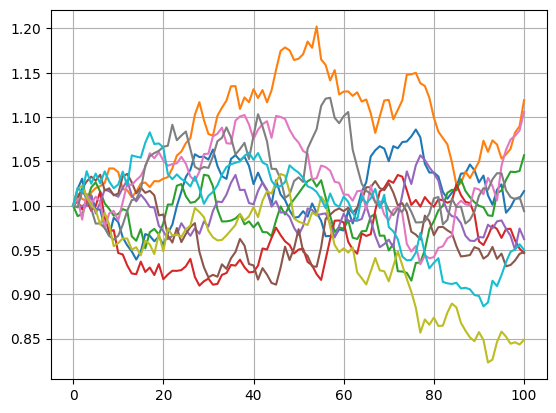

In [ ]:
from pfhedge.instruments import BrownianStock
stock_GBM = BrownianStock()
print(stock_GBM.__dict__)

stock_GBM.simulate(n_paths=N_PATHS, time_horizon = 100 / 250, init_state=(1.0,)) #initial stock price 1.0
paths_GBM = stock_GBM.spot

plt.plot(paths_GBM[:10].T)
plt.grid()
paths_GBM.shape

# Financial derivatives

{'pricer': None, 'cost': 0.0, '_clauses': OrderedDict(), '_underliers': OrderedDict([('underlier', BrownianStock(sigma=0.2000, dt=0.0040))]), 'call': True, 'strike': 1.0, 'maturity': 0.08}


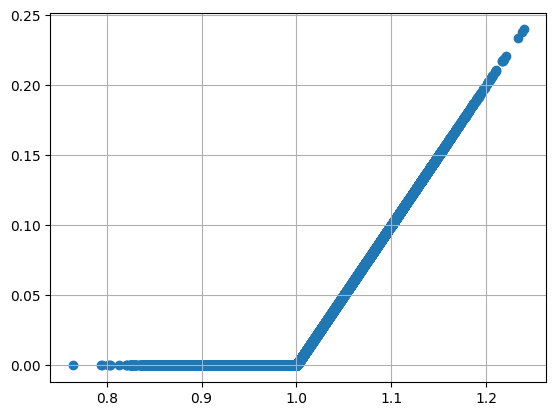

In [ ]:
from pfhedge.instruments import EuropeanOption
EuropeanCallOption = EuropeanOption(stock_GBM)
print(EuropeanCallOption.__dict__)


EuropeanCallOption.simulate(N_PATHS) # Runs MonteCarlo simulation for the option
payoff = EuropeanCallOption.payoff_fn()
underlying = EuropeanCallOption.ul() # ul() returns the underlying asset
prices = underlying.spot[:,-1]       # Extracts the stock price at expiration
plt.scatter(prices,payoff)
plt.grid()

# Hedging via ML
Defines a neural network (MultiLayerPerceptron()) to learn an optimal hedging strategy.

In [ ]:
from pfhedge.nn import Hedger
from pfhedge.nn import MultiLayerPerceptron

model = MultiLayerPerceptron()
hedger = Hedger(model, inputs=["log_moneyness", "expiry_time", "volatility"])

In [ ]:
model

MultiLayerPerceptron(
  (0): LazyLinear(in_features=0, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=1, bias=True)
  (9): Identity()
)

In [ ]:
# compute hedge
hedges = []
for t in range(10):

    # Extracts option-related features (log_moneyness, expiry_time, volatility)
    # for time t.
    inputs = hedger.inputs.of(EuropeanCallOption, hedger).get(t)

    # Passes them through the trained neural network (hedger.model)
    # to get the optimal hedge position.
    hedge = hedger.model(inputs)
    hedges.append(hedge)

In [ ]:
# compute terminal wealth
wealth = 0
for t in range(10):
    # The hedge position at t is multiplied by stock price changes (ΔS_t)
    wealth += hedges[t][:,0,0]*(paths_GBM[:,t+1] - paths_GBM[:,t])

# Final portfolio value after hedging, subtracting the option payoff
terminal_wealth = wealth - EuropeanCallOption.payoff_fn()

The **Entropic Risk Measure** is a risk measure used in financial mathematics to quantify the risk of a portfolio. It is based on exponential utility, which captures the idea that investors are risk-averse and prefer certainty over uncertain outcomes.

$$
\text{ERM}_\gamma(X) = \frac{1}{\gamma} \log \mathbb{E} \left[ e^{-\gamma X} \right]
$$



where:  
- $X$ is the random payoff (e.g., terminal wealth of a hedging strategy).  
- $\gamma > 0$ is the risk aversion parameter. By default, $\gamma =1$.

In [ ]:
# compute loss
from pfhedge.nn.functional import entropic_risk_measure
loss = entropic_risk_measure(terminal_wealth)

In [ ]:
history = hedger.fit(EuropeanCallOption, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0227: 100%|██████████| 100/100 [37:45<00:00, 22.66s/it]


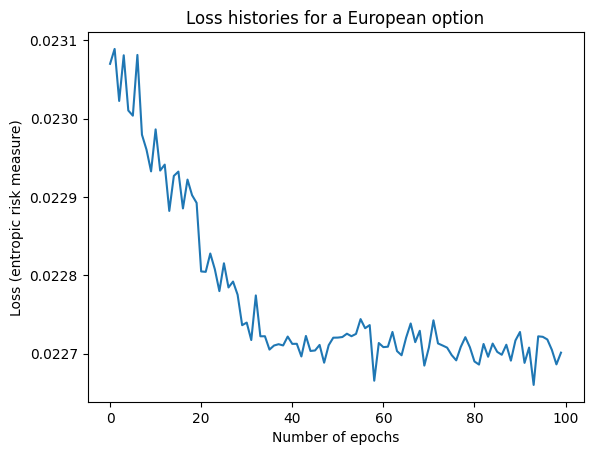

In [ ]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

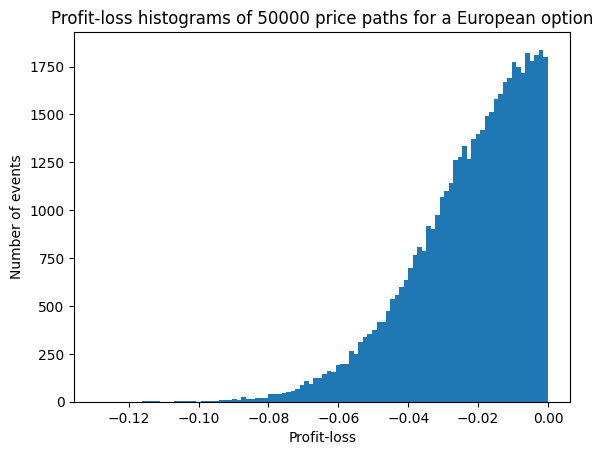

In [ ]:
# This code generates a histogram of the profit-and-loss (PnL) distribution
# over 50,000 simulated price paths of a European call option. The PnL is
# computed by the hedger object using the hedging strategy.

def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.detach().numpy()

derivative = EuropeanCallOption
pnl = hedger.compute_pnl(derivative, n_paths=50000)

plt.figure()
plt.hist(to_numpy(pnl), bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [ ]:
price = hedger.price(derivative)
price

tensor(0.0229)

# Black-Scholes' Delta-Hedging Strategy
Delta (Δ) represents the change in the option price relative to changes in the underlying asset's price.
Delta hedging aims to neutralize the price risk of an option by adjusting the position in the underlying asset.

In [ ]:
from pfhedge.nn import Hedger
from pfhedge.nn import BlackScholes

derivative = EuropeanCallOption
model = BlackScholes(derivative)
hedger = Hedger(model, inputs=model.inputs()).to(DEVICE)

In [ ]:
hedger

Hedger(
  inputs=['log_moneyness', 'time_to_maturity', 'volatility']
  (model): BSEuropeanOption(strike=1.)
  (criterion): EntropicRiskMeasure()
)

In [ ]:
price = hedger.price(derivative)
price

tensor(0.0225)

# Whalley-Wilmott's Asymptotically Optimal Strategy for Small Costs
This strategy addresses the problem of option hedging in the presence of small transaction costs. Even if in the Black-Scholes model we consider transaction costs are assumed to be zero, it is interesting to see the behaviour of this strategy. Real markets always involve small but non-zero transaction costs, such as bid-ask spreads and commissions.

In [ ]:
from pfhedge.nn import Hedger
from pfhedge.nn import WhalleyWilmott

model = WhalleyWilmott(derivative)
hedger = Hedger(model, inputs=model.inputs()).to(DEVICE)

In [ ]:
price = hedger.price(derivative)
price

tensor(0.0227)

# Build your own model!

In [ ]:
import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module

from pfhedge.nn import BlackScholes, Clamp, MultiLayerPerceptron

"""
This class implements a No-Transaction Band Hedging strategy using a neural network.
It adjusts the hedging strategy based on the Black-Scholes delta and a learned band width.
"""

class NoTransactionBandNet(Module):
    def __init__(self, derivative):
        super().__init__()

        # Black-Scholes model to compute the delta hedge
        self.delta = BlackScholes(derivative)

        # Multi-layer perceptron (MLP) to predict the no-transaction band width
        self.mlp = MultiLayerPerceptron(out_features=2)

        # Clamping layer to enforce the no-transaction band limits
        self.clamp = Clamp()

    def inputs(self):
        return self.delta.inputs() + ["prev_hedge"]

    def forward(self, input: Tensor) -> Tensor:
        prev_hedge = input[..., [-1]]
        delta = self.delta(input[..., :-1])
        width = self.mlp(input[..., :-1])

        min = delta - fn.leaky_relu(width[..., [0]])
        max = delta + fn.leaky_relu(width[..., [1]])
        return self.clamp(prev_hedge, min=min, max=max)

In [ ]:
model = NoTransactionBandNet(derivative)
hedger = Hedger(model, inputs=model.inputs())

In [ ]:
history = hedger.fit(derivative, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0226: 100%|██████████| 100/100 [18:26<00:00, 11.07s/it]


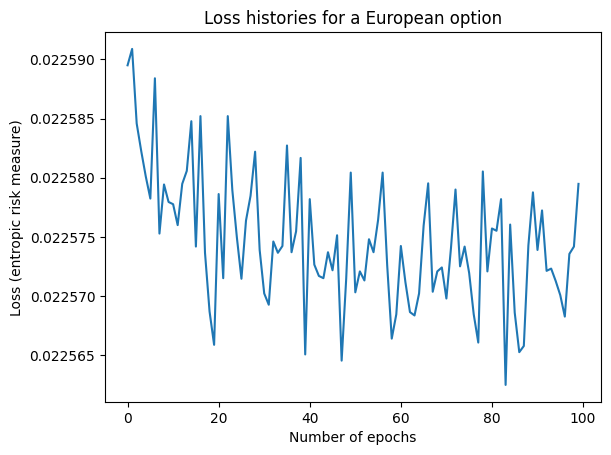

In [ ]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

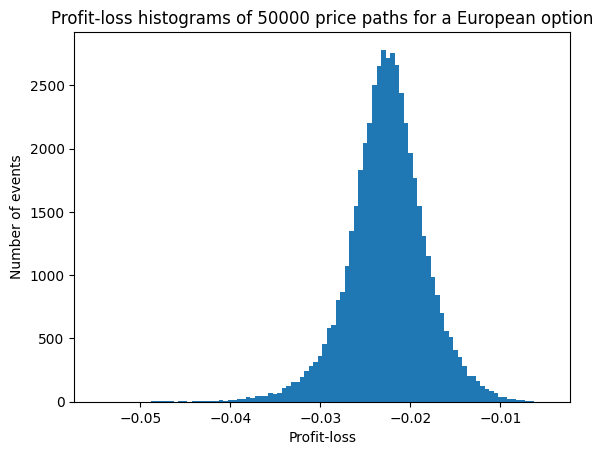

In [ ]:
pnl = hedger.compute_pnl(derivative, n_paths=50000)

plt.figure()
pnl_numpy = pnl.detach().cpu().numpy()  # Convert tensor to NumPy
plt.hist(pnl_numpy, bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [ ]:
price = hedger.price(derivative)
price

tensor(0.0226)

# Use Expected Shortfall as a Loss function
In the pfhedge library, the default loss function (criterion) used for hedging strategies is typically Mean Squared Error. We now try a different criterion, which is the expected shortfall. Expected Shortfall (ES) is a risk measure used to assess the potential loss in the tail of a distribution beyond a certain Value at Risk (VaR) threshold (in this case 90%).

Given a confidence level $\alpha$, ES at that level is defined as the conditional expectation of the loss, given that the loss is greater than or equal to the VaR at the same confidence level.

$$
\text{ES}_\alpha = \mathbb{E}[L | L \geq \text{VaR}_\alpha]
$$

Where:
- $L$ is the loss (or return in financial contexts).
- $\text{VaR}_\alpha$ is the Value at Risk at the confidence level \(\alpha\).

In [ ]:
from pfhedge.nn import ExpectedShortfall

In [ ]:
# Expected shortfall with the quantile level of 10%
expected_shortfall = ExpectedShortfall(0.1)

model = NoTransactionBandNet(derivative)
hedger = Hedger(model, inputs=model.inputs(), criterion=expected_shortfall).to(DEVICE)

In [ ]:
history = hedger.fit(derivative, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0306: 100%|██████████| 100/100 [18:27<00:00, 11.08s/it]


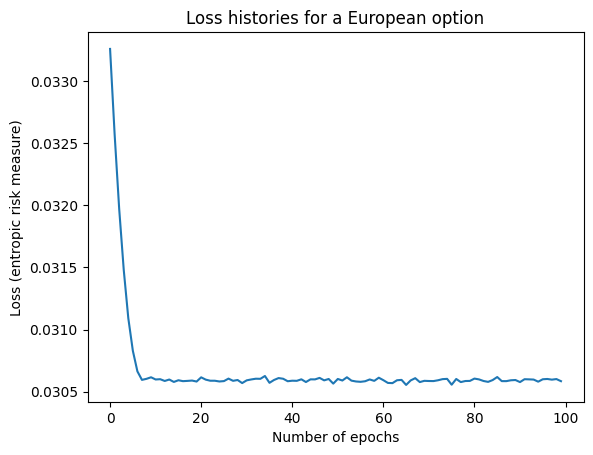

In [ ]:
plt.plot(history)
plt.xlabel("Number of epochs")
plt.ylabel("Loss (entropic risk measure)")
plt.title("Loss histories for a European option")
plt.show()

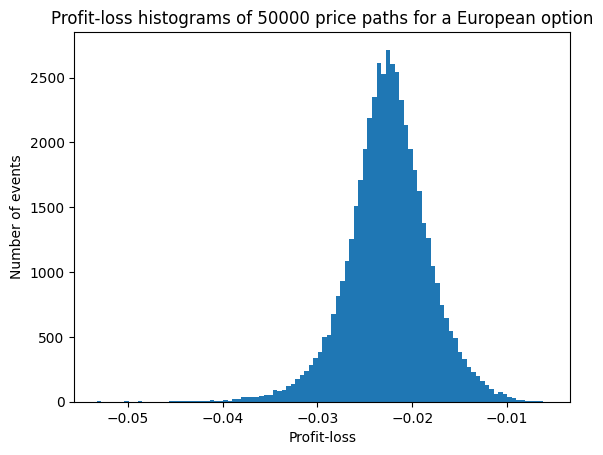

In [ ]:
pnl = hedger.compute_pnl(derivative, n_paths=50000)

plt.figure()
pnl_numpy = pnl.detach().cpu().numpy()  # Convert tensor to NumPy
plt.hist(pnl_numpy, bins=100)
plt.title("Profit-loss histograms of 50000 price paths for a European option")
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.show()

In [ ]:
price = hedger.price(derivative)
price

tensor(0.0309)